# Import image

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import scipy.ndimage

player = 3
hole = 9

image = cv2.imread('images/score3.jpg')
height, width, channels = image.shape

plt.imshow(image)
plt.show()

print('width', width)
print('height', height)

<Figure size 640x480 with 1 Axes>

width 3350
height 609


# Blur image

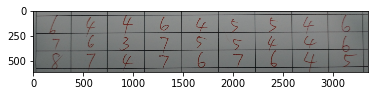

In [2]:
blurredImage = cv2.GaussianBlur(image, (9, 9), 0)

plt.imshow(blurredImage)
plt.show()

# Image thresholding

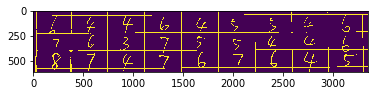

In [3]:
grayImage = cv2.cvtColor(blurredImage, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(grayImage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = 255 - thresh
cv2.imwrite("images/imgPre/thresholding.jpg", thresh)

plt.imshow(thresh)
plt.show()

# Canny

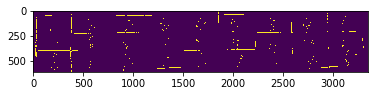

In [4]:
binaryImage = cv2.Canny(thresh, 100, 300)

cv2.imwrite("images/imgPre/canny.jpg", binaryImage)

plt.imshow(binaryImage)
plt.show()

# Erode、Dilate

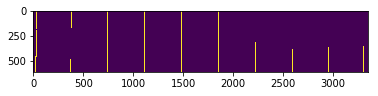

83

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
kernel_length = np.array(image).shape[1] // 40

verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
img_temp1 = cv2.erode(thresh, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
img_temp2 = cv2.erode(thresh, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

cv2.imwrite("images/imgPre/verticle_lines_img.jpg", verticle_lines_img)
cv2.imwrite("images/imgPre/horizontal_lines_img.jpg", horizontal_lines_img)

plt.imshow(verticle_lines_img)
plt.show()
kernel_length

# Merge

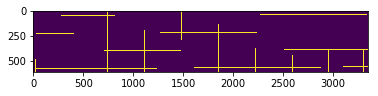

In [6]:
alpha = 0.5
beta = 1.0 - alpha

img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(img_final_bin, kernel, iterations=1)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

cv2.imwrite("images/imgPre/img_final_bin.jpg", img_final_bin)

plt.imshow(img_final_bin)
plt.show()

In [7]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# FindContours

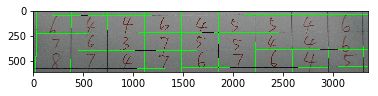

In [8]:
im2, cnts, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# (cnts, boundingBoxes) = sort_contours(cnts, method="top-to-bottom")
clone = image.copy()

cv2.drawContours(clone, cnts, -1, (0, 255, 0), 2)

cv2.imwrite("images/imgPre/findContours.jpg", clone)

plt.imshow(clone)
plt.show()

# Crop

In [9]:
cropWidth = width / hole
cropHeight = height / player
minCropX = 1000
minCropY = 1000
rectWidth = 0
rectHeight = 0

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    
    if cropWidth - (cropWidth * 0.2) < w and w < cropWidth and cropHeight - (cropHeight * 0.2) < h and h < cropHeight:            
        rectWidth = w
        rectHeight = h
        minCropX = x
        minCropY = y
        
while (minCropX - rectWidth) > 0 :
    minCropX = minCropX - rectWidth
while (minCropY - rectHeight) > 0 :
    minCropY = minCropY - rectHeight

for y in range(0, 3):
    for x in range(0, 9):
        new_img = image[minCropY+rectHeight*y: (minCropY+rectHeight*y) + rectHeight , minCropX+rectWidth*x: (minCropX+rectWidth*x) + rectWidth]
        cv2.imwrite('images/crop/' + str(y) + str(x) + '.jpg', new_img)

print('cropWidth', cropWidth)
print('cropHeight', cropHeight)
print('rectWidth', rectWidth)
print('rectHeight', rectHeight)
print('minCropX', minCropX)
print('minCropY', minCropY)

cropWidth 372.22222222222223
cropHeight 203.0
rectWidth 367
rectHeight 175
minCropX 19
minCropY 36


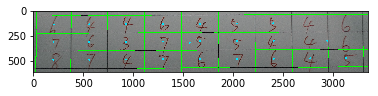

In [10]:
for c in cnts:
    M = cv2.moments(c)
    
    if M['m00'] != 0:
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        cv2.circle(clone, (cX, cY), 10, (1, 227, 254), -1)
    
cv2.imwrite("images/imgPre/middle.jpg", clone)

plt.imshow(clone)
plt.show()

In [11]:
# def getBestShift(img):
#     cy,cx = scipy.ndimage.measurements.center_of_mass(img)

#     rows,cols = img.shape
#     shiftx = np.round(cols/2.0-cx).astype(int)
#     shifty = np.round(rows/2.0-cy).astype(int)

#     return shiftx,shifty

# def shift(img,sx,sy):
#     rows,cols = img.shape
#     M = np.float32([[1,0,sx],[0,1,sy]])
#     shifted = cv2.warpAffine(img,M,(cols,rows))
#     return shifted

# # create an array where we can store our 4 pictures
# images = np.zeros((1,784))
# # and the correct values
# correct_vals = np.zeros((1,10))

# # we want to test our images which you saw at the top of this page
# i = 0
# for no in [3]:
#     # read the image
#     gray = cv2.imread("images/crop/00.jpg", cv2.IMREAD_GRAYSCALE)
    
#     # resize the images and invert it (black background)
#     gray = cv2.resize(255-gray, (28, 28))
#     (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     while np.sum(gray[0]) == 0:
#         gray = gray[1:]

#     while np.sum(gray[:,0]) == 0:
#         gray = np.delete(gray,0,1)

#     while np.sum(gray[-1]) == 0:
#         gray = gray[:-1]

#     while np.sum(gray[:,-1]) == 0:
#         gray = np.delete(gray,-1,1)

#     rows,cols = gray.shape
    
#     if rows > cols:
#         factor = 20.0/rows
#         rows = 20
#         cols = int(round(cols*factor))
#         gray = cv2.resize(gray, (cols,rows))
#     else:
#         factor = 20.0/cols
#         cols = 20
#         rows = int(round(rows*factor))
#         gray = cv2.resize(gray, (cols, rows))

#     colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
#     rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
#     gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
#     shiftx,shifty = getBestShift(gray)
#     shifted = shift(gray,shiftx,shifty)
#     gray = shifted
    
#     # save the processed images
#     cv2.imwrite("images/convert2MnistImg/00.jpg", gray)


In [12]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#Load mnist
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
"""
a placeholder for our image data:
None stands for an unspecified number of images
784 = 28*28 pixel
"""
x = tf.placeholder("float", [None, 784])

# we need our weights for our neural net
W = tf.Variable(tf.zeros([784,10]))
# and the biases
b = tf.Variable(tf.zeros([10]))

"""
softmax provides a probability based output
we need to multiply the image values x and the weights
and add the biases
(the normal procedure, explained in previous articles)
"""
y = tf.nn.softmax(tf.matmul(x,W) + b)

"""
y_ will be filled with the real values
which we want to train (digits 0-9)
for an undefined number of images
"""
y_ = tf.placeholder("float", [None,10])

"""
we use the cross_entropy function
which we want to minimize to improve our model
"""
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

"""
use a learning rate of 0.01
to minimize the cross_entropy error
"""
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# initialize all variables
init = tf.initialize_all_variables()

# create a session
sess = tf.Session()
sess.run(init)

# use 1000 batches with a size of 100 each to train our net
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  # run the train_step function with the given image values (x) and the real output (y_)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

"""
Let's get the accuracy of our model:
our model is correct if the index with the highest y value
is the same as in the real digit vector
The mean of the correct_prediction gives us the accuracy.
We need to run the accuracy function
with our test set (mnist.test)
We use the keys "images" and "labels" for x and y_
"""
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print (sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0.9194


In [22]:
def getBestShift(img):
    cy,cx = scipy.ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

# create an array where we can store our 4 pictures
images = np.zeros((1,784))
# and the correct values
correct_vals = np.zeros((1,10))

# we want to test our images which you saw at the top of this page
i = 0
for no in [3]:
    # read the image
    gray = cv2.imread("images/crop/10.jpg", cv2.IMREAD_GRAYSCALE)
    
    # resize the images and invert it (black background)
    gray = cv2.resize(255-gray, (28, 28))
    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows))

    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted
    
    # save the processed images
    cv2.imwrite("images/convert2MnistImg/00.jpg", gray)
    """
    all images in the training set have an range from 0-1
    and not from 0-255 so we divide our flatten images
    (a one dimensional vector with our 784 pixels)
    to use the same 0-1 based range
    """
    flatten = gray.flatten() / 255.0
    """
    we need to store the flatten image and generate
    the correct_vals array
    correct_val for the first digit (9) would be
    [0,0,0,0,0,0,0,0,0,1]
    """
    images[i] = flatten
    correct_val = np.zeros((10))
    correct_val[no] = 1
    correct_vals[i] = correct_val
    i += 1

"""
the prediction will be an array with four values,
which show the predicted number
"""
prediction = tf.argmax(y,1)
"""
we want to run the prediction and the accuracy function
using our generated arrays (images and correct_vals)
"""
print (sess.run(prediction, feed_dict={x: np.reshape(images, (1,-1)), y_: correct_vals}))
print (sess.run(accuracy, feed_dict={x: np.reshape(images, (1,-1)), y_: correct_vals}))



[7]
0.0
